In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import XLMRobertaModel, CLIPModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Loading the validation  dataset 
df= pd.read_csv(r"D:\Dataset\MNNIT_Insternship_MLP\MultiOFF\Split Dataset-20250706T125159Z-1-001\Split Dataset\Validation_meme_dataset.csv")
df.head()

,image_name,sentence,label
0,Xxc4mjq.png,WE LIKE IKE I LIKE IKE FRANK CULOTTA REPUBLICA...,offensive
1,ZffTHk2.png,Glory to Bern .,offensive
2,TyYDiSx.png,My mom got kicked out of her emotionally abusi...,Non-offensiv
3,FsAbNtn.png,J. TRUMP DONALD MA DE N MEXIC i RN 47333,Non-offensiv
4,ERe2yR0.png,score hidden ] 5 hours ago My friend committed...,Non-offensiv


In [5]:
df = df.rename(columns={'image_name': 'index'})
df = df.rename(columns={'sentence': 'text'})
df.replace({
    "offensive" :1 , "Non-offensiv" : 0
} , inplace = True)

In [6]:
#df.to_csv("fine_tuning_data.csv" , index = False)

In [7]:
df.head()

,index,text,label
0,Xxc4mjq.png,WE LIKE IKE I LIKE IKE FRANK CULOTTA REPUBLICA...,1
1,ZffTHk2.png,Glory to Bern .,1
2,TyYDiSx.png,My mom got kicked out of her emotionally abusi...,0
3,FsAbNtn.png,J. TRUMP DONALD MA DE N MEXIC i RN 47333,0
4,ERe2yR0.png,score hidden ] 5 hours ago My friend committed...,0


In [8]:
df.dtypes

index    object
text     object
label     int64
dtype: object

## Fine-tunning XLM-Roberta

In [9]:
# iNITALIZATION OF THE MODEL
# Initialize Tokenizer
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
# 3. Load Pretrained Model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

# 1. Define Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        self.label = torch.tensor(labels.tolist(), dtype=torch.long)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.label[idx]
        return item


In [11]:
# 2. Load and Prepare Data
# Only keep necessary columns
texts = df['text']
labels = df['label']

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=24
)

# Create Datasets
train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)

# 4. Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results_xlm_roberta",
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    seed=42,
    fp16=True,  # Set to True if using GPU with mixed precision support
    report_to="none",  # Change to "tensorboard" or "wandb" for external logging
)


# 5. Define Compute Metrics Function (Optional)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [10]:
# 6. Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


# 7. Start Training
print("Starting training...")
trainer.train()


Starting training...


C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.690267,0.600000,0.000000,0.000000,0.000000
2,No log,0.680241,0.600000,0.000000,0.000000,0.000000
3,0.697600,0.678499,0.600000,0.000000,0.000000,0.000000
4,0.697600,0.677344,0.600000,0.000000,0.000000,0.000000
5,0.669600,0.677197,0.600000,0.000000,0.000000,0.000000
6,0.669600,0.727962,0.500000,0.400000,0.384615,0.416667
7,0.669600,0.682259,0.566667,0.000000,0.000000,0.000000
8,0.628600,0.718380,0.533333,0.416667,0.416667,0.416667
9,0.628600,0.946712,0.333333,0.473684,0.346154,0.750000
10,0.498300,0.857566,0.466667,0.272727,0.300000,0.250000


C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_G

TrainOutput(global_step=80, training_loss=0.38091338872909547, metrics={'train_runtime': 151.6502, 'train_samples_per_second': 15.694, 'train_steps_per_second': 0.528, 'total_flos': 156551077939200.0, 'train_loss': 0.38091338872909547, 'epoch': 20.0})

In [11]:
# 8. Save the Final Model

model.save_pretrained("./xlm_roberta_hate_speech_Multi", safe_serialization=False)
tokenizer.save_pretrained("./xlm_roberta_hate_speech_Multi")


# 9. Evaluate Final Model
results = trainer.evaluate()
print("Final Evaluation Results:")
print(results)

Final Evaluation Results:
{'eval_loss': 1.3184397220611572, 'eval_accuracy': 0.6333333333333333, 'eval_f1': 0.5599999999999999, 'eval_precision': 0.5384615384615384, 'eval_recall': 0.5833333333333334, 'eval_runtime': 0.293, 'eval_samples_per_second': 102.39, 'eval_steps_per_second': 3.413, 'epoch': 20.0}


## Fine-tuning CLIP

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    CLIPModel,
    CLIPProcessor,
    Trainer,
    TrainingArguments
)
import pandas as pd
from PIL import Image
import os


# 1. Define Custom Dataset
class CLIPFineTuneDataset(Dataset):
    def __init__(self, csv_file, img_dir, processor, max_length=77):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.img_dir, row['index'])
        image = Image.open(image_path).convert("RGB")

        encoding = self.processor(
            text=row['text'],
            images=image,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(row['label'], dtype=torch.long)
        return item


# 2. Define Wrapped CLIP Model with Classification Head
class CLIPForBinaryClassification(CLIPModel):
    def __init__(self, config):
        super().__init__(config)
        self.classifier = nn.Linear(config.projection_dim * 2, 1)  # Combine image + text embeddings

    def forward(self, input_ids=None, attention_mask=None, pixel_values=None, labels=None):
        # Get image and text features
        image_embeds = self.get_image_features(pixel_values)

        text_outputs = self.get_text_features(input_ids)
        text_embeds = text_outputs

        # Concatenate
        combined = torch.cat([image_embeds, text_embeds], dim=1)

        # Classifier
        logits = self.classifier(combined).squeeze(-1)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())

        return {
            "loss": loss,
            "logits": logits
        }

In [13]:
csv_file = r"C:\Users\Durgesh_Verma\Desktop\AI-ML\Deep_learning\Internship_NLP\Multi\fine_tuning_data.csv"
img_dir = r"D:\Dataset\MNNIT_Insternship_MLP\MultiOFF\Labelled Images"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPForBinaryClassification.from_pretrained("openai/clip-vit-base-patch32")

C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CLIPForBinaryClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch32 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
dataset = CLIPFineTuneDataset(csv_file=csv_file, img_dir=img_dir, processor=processor)

# Split into train/val
train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [15]:
training_args = TrainingArguments(
    output_dir="./clip_binary_classifier",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    learning_rate=1e-5,
    report_to="none",
    remove_unused_columns=True  # This removes extra inputs like attention_mask# Important: keep all inputs
)

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.4).astype(int)

    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='binary'),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary')
    }

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Starting fine-tuning...")
trainer.train()

# Save final model
model.save_pretrained("./clip_binary_classifier_Multi")
processor.save_pretrained("./clip_binary_classifier_Multi")

Starting fine-tuning...


C:\Users\Durgesh_Verma\anaconda3\envs\Hybrid_GPU\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.687035,0.600000,0.142857,1.000000,0.076923
2,0.636700,0.668535,0.533333,0.125000,0.333333,0.076923
3,0.372500,0.686419,0.566667,0.434783,0.500000,0.384615
4,0.187600,0.725591,0.566667,0.235294,0.500000,0.153846
5,0.060800,0.777480,0.533333,0.363636,0.444444,0.307692
6,0.060800,1.004974,0.466667,0.333333,0.363636,0.307692
7,0.015500,1.174530,0.466667,0.272727,0.333333,0.230769
8,0.004900,1.286509,0.466667,0.200000,0.285714,0.153846
9,0.002400,1.383511,0.466667,0.333333,0.363636,0.307692
10,0.001700,1.451905,0.466667,0.333333,0.363636,0.307692


# Calling the fine-tuned models & Feture extraction

In [17]:
from transformers import XLMRobertaModel, CLIPModel, CLIPProcessor, XLMRobertaTokenizerFast
from transformers import XLMRobertaForSequenceClassification
# Load XLM-RoBERTa

xlmr_tokenizer = XLMRobertaTokenizerFast.from_pretrained("./xlm_roberta_hate_speech_Multi")
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("./xlm_roberta_hate_speech_Multi")

# Load CLIP
clip_model = CLIPModel.from_pretrained("./clip_binary_classifier_Multi")
clip_processor = CLIPProcessor.from_pretrained("./clip_binary_classifier_Multi")

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
from transformers import CLIPProcessor, XLMRobertaTokenizerFast

class MultiModalDataset(Dataset):
    def __init__(self, csv_file, img_dir, clip_processor, xlmr_tokenizer, max_length_clip=77, max_length_xlmr=128):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.clip_processor = clip_processor
        self.xlmr_tokenizer = xlmr_tokenizer
        self.max_length_clip = max_length_clip
        self.max_length_xlmr = max_length_xlmr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = os.path.join(self.img_dir, str(row['index']))

        image = Image.open(image_path).convert("RGB")

        # Process image and text with CLIP (use max_length=77 for CLIP)
        clip_inputs = self.clip_processor(
            text=row["text"],
            images=image,
            padding="max_length",
            truncation=True,
            max_length=self.max_length_clip,
            return_tensors="pt"
        )

        # Process text with XLM-RoBERTa (can still use 128)
        xlmr_inputs = self.xlmr_tokenizer(
            row["text"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length_xlmr,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in clip_inputs.items()}
        item["xlmr_input_ids"] = xlmr_inputs["input_ids"].squeeze(0)
        item["xlmr_attention_mask"] = xlmr_inputs["attention_mask"].squeeze(0)
        item["label"] = torch.tensor(row["label"], dtype=torch.long)

        return item

In [19]:
csv_file = r"C:\Users\Durgesh_Verma\Desktop\AI-ML\Deep_learning\Internship_NLP\Multi\train_Data.csv"
img_dir = r"D:\Dataset\MNNIT_Insternship_MLP\MultiOFF\Labelled Images"

# Load processor/tokenizer
clip_processor = CLIPProcessor.from_pretrained("./clip_binary_classifier_Multi")
xlmr_tokenizer = XLMRobertaTokenizerFast.from_pretrained("./xlm_roberta_hate_speech_Multi")

# Create dataset
dataset = MultiModalDataset(
    csv_file=csv_file,
    img_dir=img_dir,
    clip_processor=clip_processor,
    xlmr_tokenizer=xlmr_tokenizer
)

# Create dataloader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [20]:
import torch
from tqdm import tqdm  # <-- Added for progress bar

def extract_features(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu", modality="text"):
    model.to(device)
    model.eval()
    features = []

    # Wrap your loop with tqdm
    progress_bar = tqdm(dataloader, desc=f"Extracting {modality} features", total=len(dataloader))

    with torch.no_grad():
        for batch in progress_bar:
            if modality == "text":
                input_ids = batch["xlmr_input_ids"].to(device)
                attention_mask = batch["xlmr_attention_mask"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                batch_features = outputs.last_hidden_state[:, 0, :]  # [CLS] token
                features.append(batch_features.cpu())

            elif modality == "image":
                pixel_values = batch["pixel_values"].to(device)
                batch_features = model.get_image_features(pixel_values=pixel_values)
                features.append(batch_features.cpu())

            elif modality == "clip_text":
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                batch_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
                features.append(batch_features.cpu())

            # Update progress bar
            progress_bar.update()

    return torch.cat(features, dim=0)

In [21]:
from transformers import XLMRobertaModel, CLIPModel

# Load base models
xlmr_base_model = XLMRobertaModel.from_pretrained("./xlm_roberta_hate_speech_Multi")
clip_base_model = CLIPModel.from_pretrained("./clip_binary_classifier_Multi")

# Extract features
xlmr_features = extract_features(xlmr_base_model, dataloader, modality="text")
clip_image_features = extract_features(clip_base_model, dataloader, modality="image")
clip_text_features = extract_features(clip_base_model, dataloader, modality="clip_text")

print("XLM-RoBERTa features shape:", xlmr_features.shape)
print("CLIP image features shape:", clip_image_features.shape)
print("CLIP text features shape:", clip_text_features.shape)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at ./xlm_roberta_hate_speech_Multi and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting clip_text features: 100%|███████████████████████████████████████████████████| 28/28 [00:25<00:00,  1.11it/s]

XLM-RoBERTa features shape: torch.Size([445, 768])
CLIP image features shape: torch.Size([445, 512])
CLIP text features shape: torch.Size([445, 512])


# Combining the Features

In [22]:
#xlmr_features = torch.load("xlmr_features.pt")        # [N, 768]
#clip_image_features = torch.load("clip_image_features.pt")  # [N, 512]
#clip_text_features = torch.load("clip_text_features.pt")    # [N, 512]


#xlmr_features = torch.tensor(np.load("xlmr_features_HM.npy"))
#clip_image_features = torch.tensor(np.load("clip_image_features_HM.npy"))
#clip_text_features = torch.tensor(np.load("clip_text_features_HM.npy"))

# Concatenate all features
combined_features_train = torch.cat([
    xlmr_features,
    clip_image_features,
    clip_text_features,
], dim=1)  # shape: [N, 1792]

In [24]:
import numpy as np

np.save("xlmr_features_Multi.npy", xlmr_features.numpy())
np.save("clip_image_features_Multi.npy", clip_image_features.numpy())
np.save("clip_text_features_Multi.npy", clip_text_features.numpy())

In [46]:
# Validation dataset

In [23]:
# Create dataset
csv_file_val = r"C:\Users\Durgesh_Verma\Desktop\AI-ML\Deep_learning\Internship_NLP\Multi\fine_tuning_data.csv"

dataset = MultiModalDataset(
    csv_file=csv_file_val,
    img_dir=img_dir,
    clip_processor=clip_processor,
    xlmr_tokenizer=xlmr_tokenizer
)

# Create dataloader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Extract features
xlmr_features = extract_features(xlmr_base_model, dataloader, modality="text")
clip_image_features = extract_features(clip_base_model, dataloader, modality="image")
clip_text_features = extract_features(clip_base_model, dataloader, modality="clip_text")

# Concatenate all features
combined_features_validation = torch.cat([
    xlmr_features,
    clip_image_features,
    clip_text_features,
], dim=1)  # shape: [N, 1792]

Extracting clip_text features: 100%|███████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


In [24]:
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

df_train = pd.read_csv(csv_file)
df_val = pd.read_csv(csv_file_val)

labels_val = torch.tensor(df_val['label'].values)
labels_train = torch.tensor(df_train['label'].values)


train_dataset = data_utils.TensorDataset(combined_features_train, labels_train)
val_dataset = data_utils.TensorDataset(combined_features_validation, labels_val)

train_loader = data_utils.DataLoader(train_dataset, batch_size=3, shuffle=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=3, shuffle=True)


train_loader = data_utils.DataLoader(train_dataset, batch_size=3, shuffle=True)
val_loader = data_utils.DataLoader(val_dataset, batch_size=3 , shuffle=False)

In [25]:
# Test
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=900):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute div_term and slice to match pe[:, 0::2] and pe[:, 1::2]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:(d_model // 2)])  # Fix size mismatch

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


In [26]:
# Transfomer Model
class TransformerFusionModel(nn.Module):
    def __init__(self, input_dim=1792, hidden_dim=256, num_classes=1, nhead=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # ✅ Corrected Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(256),           # Normalize input for stability
            nn.Linear(256, 256),         # Match actual input dim
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),         # ✅ Corrected input dimension
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)            # Final output logit for BCEWithLogitsLoss
        )
    def forward(self, x):
        x = self.input_proj(x.unsqueeze(1))  # [B, 1, hidden_dim]
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x).squeeze(-1)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerFusionModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 100


for epoch in range(num_epochs):
    print(f"\n🟢 Epoch {epoch + 1}/{num_epochs}")

    start_time = time.time()

    # === Train ===
    model.train()
    train_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) >= 0.4
        correct += (preds.int() == labels.int()).sum().item()
        total += labels.size(0)
        train_loss += loss.item() * labels.size(0)

        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / total
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # === Validation ===
    model.eval()
    val_loss, correct, total = 0, 0, 0

    val_loop = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs) >= 0.4
            correct += (preds.int() == labels.int()).sum().item()
            total += labels.size(0)
            val_loss += loss.item() * labels.size(0)

            val_loop.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / total
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    elapsed = time.time() - start_time
    print(f"✅ Epoch {epoch+1} complete in {elapsed:.2f}s")
    print(f"🔹 Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    print(f"🔸 Val   Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f}")



🟢 Epoch 1/100


✅ Epoch 1 complete in 5.76s
🔹 Train Loss: 0.6941 | Accuracy: 0.4472
🔸 Val   Loss: 0.6679 | Accuracy: 0.3893

🟢 Epoch 2/100


✅ Epoch 2 complete in 5.51s
🔹 Train Loss: 0.6853 | Accuracy: 0.4607
🔸 Val   Loss: 0.6555 | Accuracy: 0.3893

🟢 Epoch 3/100


✅ Epoch 3 complete in 5.73s
🔹 Train Loss: 0.6841 | Accuracy: 0.4854
🔸 Val   Loss: 0.6395 | Accuracy: 0.7718

🟢 Epoch 4/100


✅ Epoch 4 complete in 3.16s
🔹 Train Loss: 0.6807 | Accuracy: 0.4742
🔸 Val   Loss: 0.6173 | Accuracy: 0.8591

🟢 Epoch 5/100


✅ Epoch 5 complete in 1.83s
🔹 Train Loss: 0.6693 | Accuracy: 0.5618
🔸 Val   Loss: 0.6197 | Accuracy: 0.6577

🟢 Epoch 6/100


✅ Epoch 6 complete in 1.78s
🔹 Train Loss: 0.6656 | Accuracy: 0.5326
🔸 Val   Loss: 0.5872 | Accuracy: 0.5906

🟢 Epoch 7/100


✅ Epoch 7 complete in 1.83s
🔹 Train Loss: 0.6336 | Accuracy: 0.6494
🔸 Val   Loss: 0.5438 | Accuracy: 0.7584

🟢 Epoch 8/100


✅ Epoch 8 complete in 1.76s
🔹 Train Loss: 0.5921 | Accuracy: 0.6989
🔸 Val   Loss: 0.7437 | Accuracy: 0.5034

🟢 Epoch 9/100


✅ Epoch 9 complete in 1.76s
🔹 Train Loss: 0.5325 | Accuracy: 0.7303
🔸 Val   Loss: 0.5100 | Accuracy: 0.7718

🟢 Epoch 10/100


✅ Epoch 10 complete in 1.78s
🔹 Train Loss: 0.5301 | Accuracy: 0.7506
🔸 Val   Loss: 0.5126 | Accuracy: 0.7785

🟢 Epoch 11/100


✅ Epoch 11 complete in 1.76s
🔹 Train Loss: 0.3788 | Accuracy: 0.8360
🔸 Val   Loss: 0.5899 | Accuracy: 0.7651

🟢 Epoch 12/100


✅ Epoch 12 complete in 1.75s
🔹 Train Loss: 0.3986 | Accuracy: 0.8427
🔸 Val   Loss: 1.0110 | Accuracy: 0.5570

🟢 Epoch 13/100


✅ Epoch 13 complete in 1.81s
🔹 Train Loss: 0.3359 | Accuracy: 0.8764
🔸 Val   Loss: 0.4783 | Accuracy: 0.7315

🟢 Epoch 14/100


✅ Epoch 14 complete in 1.72s
🔹 Train Loss: 0.3421 | Accuracy: 0.8674
🔸 Val   Loss: 0.4107 | Accuracy: 0.8523

🟢 Epoch 15/100


✅ Epoch 15 complete in 1.77s
🔹 Train Loss: 0.3102 | Accuracy: 0.8854
🔸 Val   Loss: 1.0648 | Accuracy: 0.5369

🟢 Epoch 16/100


✅ Epoch 16 complete in 1.88s
🔹 Train Loss: 0.2537 | Accuracy: 0.9146
🔸 Val   Loss: 0.8773 | Accuracy: 0.6510

🟢 Epoch 17/100


✅ Epoch 17 complete in 1.78s
🔹 Train Loss: 0.2475 | Accuracy: 0.9079
🔸 Val   Loss: 1.0692 | Accuracy: 0.5503

🟢 Epoch 18/100


✅ Epoch 18 complete in 1.77s
🔹 Train Loss: 0.1760 | Accuracy: 0.9303
🔸 Val   Loss: 1.1210 | Accuracy: 0.6174

🟢 Epoch 19/100


✅ Epoch 19 complete in 1.82s
🔹 Train Loss: 0.1531 | Accuracy: 0.9528
🔸 Val   Loss: 1.0729 | Accuracy: 0.6577

🟢 Epoch 20/100


✅ Epoch 20 complete in 1.77s
🔹 Train Loss: 0.1410 | Accuracy: 0.9573
🔸 Val   Loss: 1.5866 | Accuracy: 0.5973

🟢 Epoch 21/100


✅ Epoch 21 complete in 1.77s
🔹 Train Loss: 0.2019 | Accuracy: 0.9191
🔸 Val   Loss: 1.0546 | Accuracy: 0.5302

🟢 Epoch 22/100


✅ Epoch 22 complete in 1.74s
🔹 Train Loss: 0.0969 | Accuracy: 0.9640
🔸 Val   Loss: 0.9682 | Accuracy: 0.6913

🟢 Epoch 23/100


✅ Epoch 23 complete in 1.71s
🔹 Train Loss: 0.0895 | Accuracy: 0.9753
🔸 Val   Loss: 0.8192 | Accuracy: 0.7785

🟢 Epoch 24/100


✅ Epoch 24 complete in 1.74s
🔹 Train Loss: 0.0947 | Accuracy: 0.9708
🔸 Val   Loss: 0.9978 | Accuracy: 0.7651

🟢 Epoch 25/100


✅ Epoch 25 complete in 1.77s
🔹 Train Loss: 0.1197 | Accuracy: 0.9618
🔸 Val   Loss: 1.5999 | Accuracy: 0.4832

🟢 Epoch 26/100


✅ Epoch 26 complete in 1.68s
🔹 Train Loss: 0.1327 | Accuracy: 0.9438
🔸 Val   Loss: 1.3411 | Accuracy: 0.6577

🟢 Epoch 27/100


✅ Epoch 27 complete in 1.72s
🔹 Train Loss: 0.1009 | Accuracy: 0.9663
🔸 Val   Loss: 0.7393 | Accuracy: 0.7785

🟢 Epoch 28/100


✅ Epoch 28 complete in 1.69s
🔹 Train Loss: 0.1409 | Accuracy: 0.9618
🔸 Val   Loss: 1.2929 | Accuracy: 0.6913

🟢 Epoch 29/100


✅ Epoch 29 complete in 1.67s
🔹 Train Loss: 0.0746 | Accuracy: 0.9798
🔸 Val   Loss: 1.4389 | Accuracy: 0.5906

🟢 Epoch 30/100


✅ Epoch 30 complete in 1.72s
🔹 Train Loss: 0.1358 | Accuracy: 0.9663
🔸 Val   Loss: 1.4263 | Accuracy: 0.5638

🟢 Epoch 31/100


✅ Epoch 31 complete in 1.75s
🔹 Train Loss: 0.0737 | Accuracy: 0.9753
🔸 Val   Loss: 1.1993 | Accuracy: 0.6913

🟢 Epoch 32/100


✅ Epoch 32 complete in 1.72s
🔹 Train Loss: 0.0548 | Accuracy: 0.9820
🔸 Val   Loss: 1.1718 | Accuracy: 0.7114

🟢 Epoch 33/100


✅ Epoch 33 complete in 1.65s
🔹 Train Loss: 0.1510 | Accuracy: 0.9551
🔸 Val   Loss: 1.0733 | Accuracy: 0.7315

🟢 Epoch 34/100


✅ Epoch 34 complete in 1.71s
🔹 Train Loss: 0.2260 | Accuracy: 0.9348
🔸 Val   Loss: 1.1201 | Accuracy: 0.6040

🟢 Epoch 35/100


✅ Epoch 35 complete in 1.66s
🔹 Train Loss: 0.1312 | Accuracy: 0.9596
🔸 Val   Loss: 0.6853 | Accuracy: 0.8054

🟢 Epoch 36/100


✅ Epoch 36 complete in 1.73s
🔹 Train Loss: 0.1643 | Accuracy: 0.9506
🔸 Val   Loss: 0.8560 | Accuracy: 0.6577

🟢 Epoch 37/100


✅ Epoch 37 complete in 1.71s
🔹 Train Loss: 0.1033 | Accuracy: 0.9663
🔸 Val   Loss: 1.0449 | Accuracy: 0.7383

🟢 Epoch 38/100


✅ Epoch 38 complete in 1.75s
🔹 Train Loss: 0.0521 | Accuracy: 0.9888
🔸 Val   Loss: 1.3025 | Accuracy: 0.6980

🟢 Epoch 39/100


✅ Epoch 39 complete in 1.70s
🔹 Train Loss: 0.0770 | Accuracy: 0.9730
🔸 Val   Loss: 0.6749 | Accuracy: 0.8456

🟢 Epoch 40/100


✅ Epoch 40 complete in 1.71s
🔹 Train Loss: 0.0767 | Accuracy: 0.9753
🔸 Val   Loss: 1.3174 | Accuracy: 0.6443

🟢 Epoch 41/100


✅ Epoch 41 complete in 1.74s
🔹 Train Loss: 0.0574 | Accuracy: 0.9843
🔸 Val   Loss: 1.3979 | Accuracy: 0.6040

🟢 Epoch 42/100


✅ Epoch 42 complete in 1.72s
🔹 Train Loss: 0.0427 | Accuracy: 0.9843
🔸 Val   Loss: 1.4387 | Accuracy: 0.6846

🟢 Epoch 43/100


✅ Epoch 43 complete in 1.68s
🔹 Train Loss: 0.0326 | Accuracy: 0.9933
🔸 Val   Loss: 1.7463 | Accuracy: 0.6577

🟢 Epoch 44/100


✅ Epoch 44 complete in 1.66s
🔹 Train Loss: 0.0293 | Accuracy: 0.9933
🔸 Val   Loss: 1.8990 | Accuracy: 0.6174

🟢 Epoch 45/100


✅ Epoch 45 complete in 1.72s
🔹 Train Loss: 0.0200 | Accuracy: 0.9910
🔸 Val   Loss: 1.8694 | Accuracy: 0.6577

🟢 Epoch 46/100


✅ Epoch 46 complete in 1.76s
🔹 Train Loss: 0.2565 | Accuracy: 0.9258
🔸 Val   Loss: 0.8172 | Accuracy: 0.7785

🟢 Epoch 47/100


✅ Epoch 47 complete in 1.71s
🔹 Train Loss: 0.1229 | Accuracy: 0.9506
🔸 Val   Loss: 1.0797 | Accuracy: 0.6846

🟢 Epoch 48/100


✅ Epoch 48 complete in 1.67s
🔹 Train Loss: 0.0331 | Accuracy: 0.9933
🔸 Val   Loss: 1.7245 | Accuracy: 0.6174

🟢 Epoch 49/100


✅ Epoch 49 complete in 1.68s
🔹 Train Loss: 0.0225 | Accuracy: 0.9933
🔸 Val   Loss: 1.6563 | Accuracy: 0.7181

🟢 Epoch 50/100


✅ Epoch 50 complete in 1.69s
🔹 Train Loss: 0.0478 | Accuracy: 0.9910
🔸 Val   Loss: 1.8495 | Accuracy: 0.6443

🟢 Epoch 51/100


✅ Epoch 51 complete in 1.70s
🔹 Train Loss: 0.1023 | Accuracy: 0.9551
🔸 Val   Loss: 1.3992 | Accuracy: 0.6779

🟢 Epoch 52/100


✅ Epoch 52 complete in 1.71s
🔹 Train Loss: 0.0381 | Accuracy: 0.9820
🔸 Val   Loss: 1.3951 | Accuracy: 0.7248

🟢 Epoch 53/100


✅ Epoch 53 complete in 1.66s
🔹 Train Loss: 0.0220 | Accuracy: 0.9910
🔸 Val   Loss: 2.6604 | Accuracy: 0.5839

🟢 Epoch 54/100


✅ Epoch 54 complete in 1.70s
🔹 Train Loss: 0.0262 | Accuracy: 0.9865
🔸 Val   Loss: 1.9060 | Accuracy: 0.6779

🟢 Epoch 55/100


✅ Epoch 55 complete in 1.70s
🔹 Train Loss: 0.0164 | Accuracy: 0.9933
🔸 Val   Loss: 3.1702 | Accuracy: 0.5638

🟢 Epoch 56/100


✅ Epoch 56 complete in 1.65s
🔹 Train Loss: 0.0807 | Accuracy: 0.9685
🔸 Val   Loss: 1.6854 | Accuracy: 0.7383

🟢 Epoch 57/100


✅ Epoch 57 complete in 1.72s
🔹 Train Loss: 0.1440 | Accuracy: 0.9573
🔸 Val   Loss: 2.0201 | Accuracy: 0.6577

🟢 Epoch 58/100


✅ Epoch 58 complete in 1.80s
🔹 Train Loss: 0.0994 | Accuracy: 0.9685
🔸 Val   Loss: 1.7042 | Accuracy: 0.5973

🟢 Epoch 59/100


✅ Epoch 59 complete in 1.80s
🔹 Train Loss: 0.0556 | Accuracy: 0.9730
🔸 Val   Loss: 1.9106 | Accuracy: 0.6711

🟢 Epoch 60/100


✅ Epoch 60 complete in 1.81s
🔹 Train Loss: 0.0191 | Accuracy: 0.9888
🔸 Val   Loss: 1.7845 | Accuracy: 0.6846

🟢 Epoch 61/100


✅ Epoch 61 complete in 1.79s
🔹 Train Loss: 0.0130 | Accuracy: 0.9955
🔸 Val   Loss: 2.1297 | Accuracy: 0.6711

🟢 Epoch 62/100


✅ Epoch 62 complete in 1.78s
🔹 Train Loss: 0.0128 | Accuracy: 0.9910
🔸 Val   Loss: 2.1944 | Accuracy: 0.6711

🟢 Epoch 63/100


✅ Epoch 63 complete in 1.84s
🔹 Train Loss: 0.0126 | Accuracy: 0.9910
🔸 Val   Loss: 2.0486 | Accuracy: 0.6846

🟢 Epoch 64/100


✅ Epoch 64 complete in 1.76s
🔹 Train Loss: 0.0247 | Accuracy: 0.9888
🔸 Val   Loss: 2.6304 | Accuracy: 0.5906

🟢 Epoch 65/100


✅ Epoch 65 complete in 1.78s
🔹 Train Loss: 0.2234 | Accuracy: 0.9213
🔸 Val   Loss: 1.1158 | Accuracy: 0.6510

🟢 Epoch 66/100


✅ Epoch 66 complete in 1.80s
🔹 Train Loss: 0.0573 | Accuracy: 0.9775
🔸 Val   Loss: 1.7618 | Accuracy: 0.6376

🟢 Epoch 67/100


✅ Epoch 67 complete in 1.74s
🔹 Train Loss: 0.1623 | Accuracy: 0.9506
🔸 Val   Loss: 1.0488 | Accuracy: 0.6376

🟢 Epoch 68/100


✅ Epoch 68 complete in 1.76s
🔹 Train Loss: 0.0280 | Accuracy: 0.9933
🔸 Val   Loss: 1.4610 | Accuracy: 0.6846

🟢 Epoch 69/100


✅ Epoch 69 complete in 1.72s
🔹 Train Loss: 0.0130 | Accuracy: 0.9955
🔸 Val   Loss: 2.0185 | Accuracy: 0.6443

🟢 Epoch 70/100


✅ Epoch 70 complete in 1.74s
🔹 Train Loss: 0.0914 | Accuracy: 0.9685
🔸 Val   Loss: 1.4302 | Accuracy: 0.6846

🟢 Epoch 71/100


✅ Epoch 71 complete in 1.85s
🔹 Train Loss: 0.0353 | Accuracy: 0.9820
🔸 Val   Loss: 1.5166 | Accuracy: 0.6913

🟢 Epoch 72/100


✅ Epoch 72 complete in 1.80s
🔹 Train Loss: 0.0147 | Accuracy: 0.9910
🔸 Val   Loss: 1.8105 | Accuracy: 0.6846

🟢 Epoch 73/100


✅ Epoch 73 complete in 1.82s
🔹 Train Loss: 0.0125 | Accuracy: 0.9933
🔸 Val   Loss: 1.8318 | Accuracy: 0.6913

🟢 Epoch 74/100


✅ Epoch 74 complete in 1.78s
🔹 Train Loss: 0.0123 | Accuracy: 0.9933
🔸 Val   Loss: 2.0025 | Accuracy: 0.6913

🟢 Epoch 75/100


✅ Epoch 75 complete in 1.80s
🔹 Train Loss: 0.0230 | Accuracy: 0.9888
🔸 Val   Loss: 2.6740 | Accuracy: 0.6040

🟢 Epoch 76/100


✅ Epoch 76 complete in 1.73s
🔹 Train Loss: 0.0568 | Accuracy: 0.9798
🔸 Val   Loss: 1.3754 | Accuracy: 0.6779

🟢 Epoch 77/100


✅ Epoch 77 complete in 1.71s
🔹 Train Loss: 0.0637 | Accuracy: 0.9843
🔸 Val   Loss: 2.2784 | Accuracy: 0.5973

🟢 Epoch 78/100


✅ Epoch 78 complete in 1.71s
🔹 Train Loss: 0.0159 | Accuracy: 0.9955
🔸 Val   Loss: 2.3797 | Accuracy: 0.6309

🟢 Epoch 79/100


✅ Epoch 79 complete in 1.71s
🔹 Train Loss: 0.0986 | Accuracy: 0.9663
🔸 Val   Loss: 1.7624 | Accuracy: 0.6577

🟢 Epoch 80/100


✅ Epoch 80 complete in 1.79s
🔹 Train Loss: 0.0142 | Accuracy: 0.9933
🔸 Val   Loss: 1.9801 | Accuracy: 0.6779

🟢 Epoch 81/100


✅ Epoch 81 complete in 1.77s
🔹 Train Loss: 0.0139 | Accuracy: 0.9910
🔸 Val   Loss: 2.0896 | Accuracy: 0.6711

🟢 Epoch 82/100


✅ Epoch 82 complete in 1.90s
🔹 Train Loss: 0.0115 | Accuracy: 0.9933
🔸 Val   Loss: 2.2028 | Accuracy: 0.6711

🟢 Epoch 83/100


✅ Epoch 83 complete in 1.73s
🔹 Train Loss: 0.0127 | Accuracy: 0.9933
🔸 Val   Loss: 2.2810 | Accuracy: 0.6644

🟢 Epoch 84/100


✅ Epoch 84 complete in 1.76s
🔹 Train Loss: 0.0103 | Accuracy: 0.9933
🔸 Val   Loss: 2.3513 | Accuracy: 0.6779

🟢 Epoch 85/100


✅ Epoch 85 complete in 1.74s
🔹 Train Loss: 0.0148 | Accuracy: 0.9933
🔸 Val   Loss: 2.9463 | Accuracy: 0.6174

🟢 Epoch 86/100


✅ Epoch 86 complete in 1.74s
🔹 Train Loss: 0.0157 | Accuracy: 0.9910
🔸 Val   Loss: 2.4618 | Accuracy: 0.6711

🟢 Epoch 87/100


✅ Epoch 87 complete in 1.76s
🔹 Train Loss: 0.0336 | Accuracy: 0.9910
🔸 Val   Loss: 1.9219 | Accuracy: 0.4832

🟢 Epoch 88/100


✅ Epoch 88 complete in 1.79s
🔹 Train Loss: 0.1143 | Accuracy: 0.9618
🔸 Val   Loss: 1.5859 | Accuracy: 0.7114

🟢 Epoch 89/100


✅ Epoch 89 complete in 1.77s
🔹 Train Loss: 0.0278 | Accuracy: 0.9888
🔸 Val   Loss: 2.6971 | Accuracy: 0.6309

🟢 Epoch 90/100


✅ Epoch 90 complete in 1.80s
🔹 Train Loss: 0.0659 | Accuracy: 0.9820
🔸 Val   Loss: 1.6393 | Accuracy: 0.5772

🟢 Epoch 91/100


✅ Epoch 91 complete in 1.82s
🔹 Train Loss: 0.1658 | Accuracy: 0.9438
🔸 Val   Loss: 0.8995 | Accuracy: 0.6913

🟢 Epoch 92/100


✅ Epoch 92 complete in 1.79s
🔹 Train Loss: 0.0593 | Accuracy: 0.9820
🔸 Val   Loss: 1.7378 | Accuracy: 0.6644

🟢 Epoch 93/100


✅ Epoch 93 complete in 1.86s
🔹 Train Loss: 0.0139 | Accuracy: 0.9955
🔸 Val   Loss: 2.1255 | Accuracy: 0.6510

🟢 Epoch 94/100


✅ Epoch 94 complete in 1.80s
🔹 Train Loss: 0.0127 | Accuracy: 0.9955
🔸 Val   Loss: 2.9816 | Accuracy: 0.5235

🟢 Epoch 95/100


✅ Epoch 95 complete in 1.83s
🔹 Train Loss: 0.0460 | Accuracy: 0.9775
🔸 Val   Loss: 1.3264 | Accuracy: 0.7852

🟢 Epoch 96/100


✅ Epoch 96 complete in 1.84s
🔹 Train Loss: 0.0818 | Accuracy: 0.9843
🔸 Val   Loss: 1.8201 | Accuracy: 0.6174

🟢 Epoch 97/100


✅ Epoch 97 complete in 1.80s
🔹 Train Loss: 0.0148 | Accuracy: 0.9933
🔸 Val   Loss: 2.3342 | Accuracy: 0.6242

🟢 Epoch 98/100


✅ Epoch 98 complete in 1.87s
🔹 Train Loss: 0.0097 | Accuracy: 0.9955
🔸 Val   Loss: 2.4282 | Accuracy: 0.6242

🟢 Epoch 99/100


✅ Epoch 99 complete in 1.90s
🔹 Train Loss: 0.0078 | Accuracy: 0.9955
🔸 Val   Loss: 2.5607 | Accuracy: 0.6242

🟢 Epoch 100/100


✅ Epoch 100 complete in 1.91s
🔹 Train Loss: 0.0078 | Accuracy: 0.9955
🔸 Val   Loss: 2.6864 | Accuracy: 0.6309


In [29]:
torch.save(model.state_dict(), "MultiOFF_model_weights.pth")


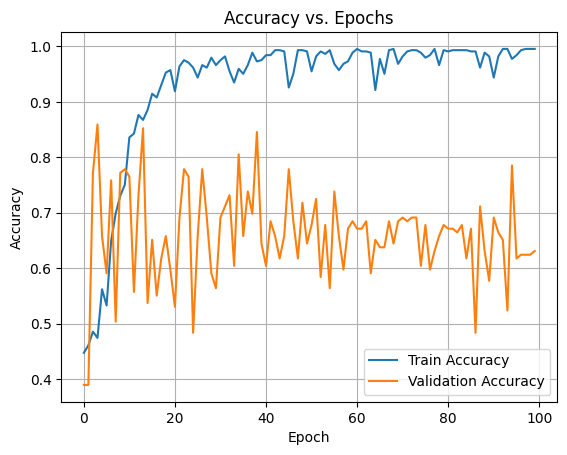

In [31]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


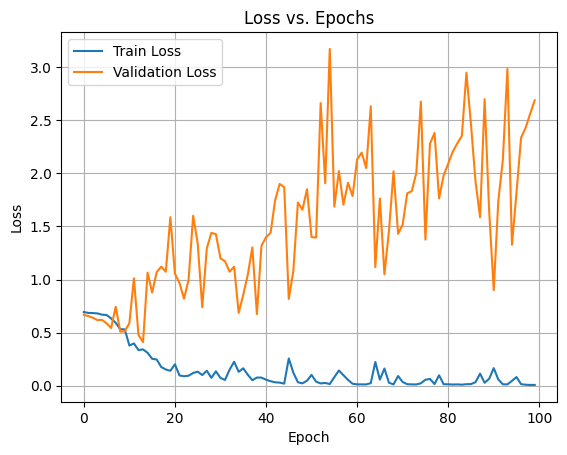

In [32]:
# Loss plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Ensure model is in eval mode
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Collecting predictions"):
        inputs = inputs.to(device)
        labels = labels.to(device).int()
        
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.4).int()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Display comparison (first 20 samples for clarity)
for i in range(10):
    print(f"Sample {i+1:2d} - True: {true_labels[i]}  |  Predicted: {predicted_labels[i]}")


Sample  1 - True: 1  |  Predicted: 0
Sample  2 - True: 1  |  Predicted: 0
Sample  3 - True: 0  |  Predicted: 1
Sample  4 - True: 0  |  Predicted: 1
Sample  5 - True: 0  |  Predicted: 0
Sample  6 - True: 0  |  Predicted: 0
Sample  7 - True: 0  |  Predicted: 0
Sample  8 - True: 1  |  Predicted: 0
Sample  9 - True: 1  |  Predicted: 1
Sample 10 - True: 0  |  Predicted: 0


In [34]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating on validation set"):
        inputs = inputs.to(device)
        labels = labels.to(device).int()
        
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.4).int()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print classification report
print("🧾 Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=4, target_names=["Not Hate", "Hate"]))


Evaluating on validation set: 100%|███████████████████████████████████████████████████| 50/50 [00:00<00:00, 255.67it/s]

🧾 Classification Report:

              precision    recall  f1-score   support

    Not Hate     0.7143    0.6593    0.6857        91
        Hate     0.5231    0.5862    0.5528        58

    accuracy                         0.6309       149
   macro avg     0.6187    0.6228    0.6193       149
weighted avg     0.6399    0.6309    0.6340       149



# Prediction on testing data

In [35]:
eval_csv = r"C:\Users\Durgesh_Verma\Desktop\AI-ML\Deep_learning\Internship_NLP\Multi\test_Data.csv"
eval_img_dir = r"D:\Dataset\MNNIT_Insternship_MLP\MultiOFF\Labelled Images"

# Use the same dataset class (with label support)
eval_dataset = MultiModalDataset(
    csv_file=eval_csv,
    img_dir=eval_img_dir,
    clip_processor=clip_processor,
    xlmr_tokenizer=xlmr_tokenizer
)
eval_loader = DataLoader(eval_dataset, batch_size=3, shuffle=False)


In [36]:
xlmr_eval_features = extract_features(xlmr_base_model, eval_loader, modality="text")
clip_image_eval_features = extract_features(clip_base_model, eval_loader, modality="image")
clip_text_eval_features = extract_features(clip_base_model, eval_loader, modality="clip_text")

# Combine all
combined_eval_features = torch.cat([
    xlmr_eval_features,
    clip_image_eval_features,
    clip_text_eval_features,
], dim=1)


Extracting clip_text features: 100%|███████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.70it/s]


In [37]:
model.eval()
all_probs = []

with torch.no_grad():
    for i in range(0, len(combined_eval_features), 8):
        batch = combined_eval_features[i:i+8].to(device)  # ✅ Move to same device as model
        outputs = model(batch)
        probs = torch.sigmoid(outputs)  # Keep raw probabilities
        all_probs.extend(probs.cpu().numpy())  # Move back to CPU for numpy


In [38]:
eval_df = pd.read_csv(eval_csv)
true_labels = eval_df["label"].values


In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

# Convert sigmoid outputs to class predictions (threshold = 0.4 as you used)
pred_labels = (np.array(all_probs) > 0.4).astype(int)

# Evaluate metrics
accuracy = accuracy_score(true_labels, pred_labels)
f1_weighted = f1_score(true_labels, pred_labels, average='weighted')
f1_macro = f1_score(true_labels, pred_labels, average='macro')
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
report = classification_report(true_labels, pred_labels)

# Print results
print(f"✅ Accuracy:           {accuracy:.4f}")
print(f"✅ Weighted F1 Score:  {f1_weighted:.4f}")
print(f"✅ Macro F1 Score:     {f1_macro:.4f}")
print(f"✅ Weighted Precision: {precision:.4f}")
print(f"✅ Weighted Recall:    {recall:.4f}")
print("\n🧾 Full Classification Report:\n", report)


✅ Accuracy:           0.6846
✅ Weighted F1 Score:  0.6882
✅ Macro F1 Score:     0.6825
✅ Weighted Precision: 0.7190
✅ Weighted Recall:    0.6846

🧾 Full Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71        91
           1       0.57      0.78      0.66        58

    accuracy                           0.68       149
   macro avg       0.69      0.70      0.68       149
weighted avg       0.72      0.68      0.69       149



✅ AUC Score: 0.7115


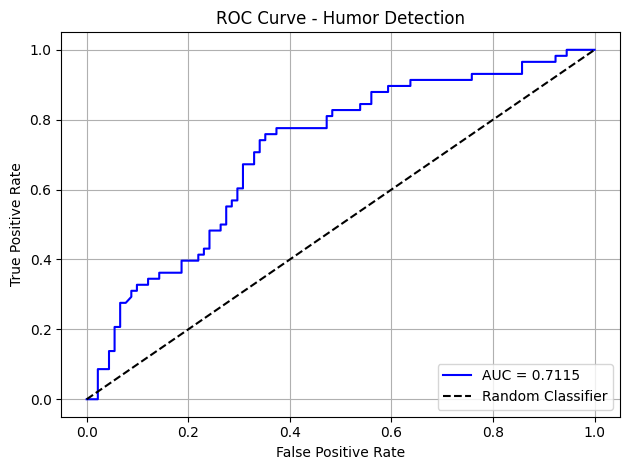

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# AUC score
auc_score = roc_auc_score(true_labels, all_probs)
print(f"✅ AUC Score: {auc_score:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(true_labels, all_probs)

# Plot
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Humor Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
